In [1]:
import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import ggplot
import seaborn as sns
import random
import xgboost
from scipy.stats import gaussian_kde
%matplotlib inline

# Table of Contents

1. Exploring the Data
2. Building a DataFrame and Standard Algorithm
3. Feature engineering/Feature Selection
4. Tuning the algorithm
5. Conclusions

## Exploring the Data


### Univariant Analysis

So lets take a first glance at what we have here:
    
- 6 files, all connected by the key 'id'. Seems like we have to break down these relations first in order to get a coherent dataframe

After quickly scrolling through the data in MS Excel, i decided to do the following:
In order to just process numeric data, i dropped the strings from all the csv files containing the description ('event_type ', 'log_feature ', 'resource_type') manually with the replace function.



| id,event_type  	|   	
|:-:	|
|62093, ~~event_type~~ 15   	|





In [2]:
train = pd.read_csv("Telstra/train.csv")
events = pd.read_csv("Telstra/event_type.csv")
log_feature = pd.read_csv("Telstra/log_feature.csv")
resources = pd.read_csv("Telstra/resource_type.csv")
test = pd.read_csv("Telstra/test.csv")
severity = pd.read_csv("Telstra/severity_type.csv")

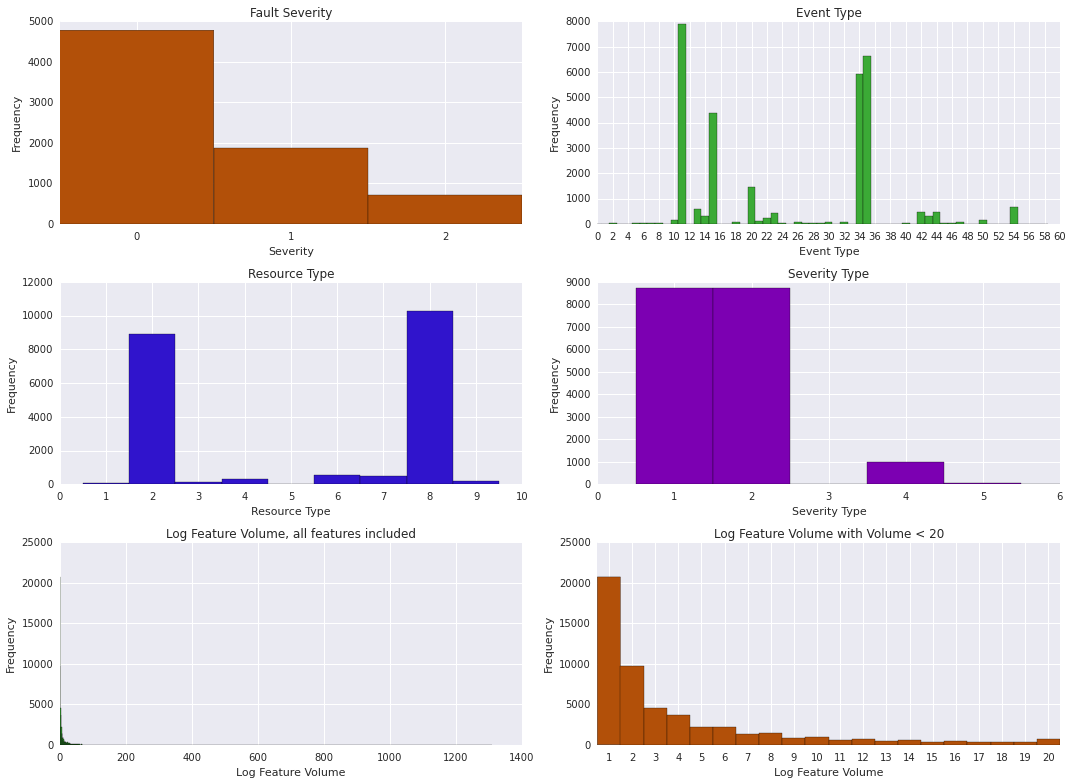

In [3]:
fig = plt.figure(figsize=(15,11))

###Fault Severity
ax1 = fig.add_subplot(321)
ax1.set_title('Fault Severity')
ax1.hist(train.fault_severity, bins=np.arange(4) - 0.5, color='#B25009')
ax1.set_xlabel('Severity')
ax1.set_ylabel('Frequency')
ax1.set_xticks(range(3))

### Event Type
ax2 = fig.add_subplot(322)
ax2.set_title('Event Type')
ax2.hist(events.event_type, bins=np.arange(60)-0.5,color='#3baa36')
ax2.set_xlabel('Event Type')
ax2.set_ylabel('Frequency')
ax2.set_xticks(range(60))
ax2.xaxis.set_major_locator(plt.MaxNLocator(30))


##Resource Type
ax3 = fig.add_subplot(323)
ax3.set_title('Resource Type')
ax3.set_ylabel('Frequency')
ax3.set_xlabel('Resource Type')
ax3.hist(resources.resource_type, bins=np.arange(11)-0.5, color = '#3014CC')
ax3.xaxis.set_major_locator(plt.MaxNLocator(10))

#Severity Type
ax4 = fig.add_subplot(324)
ax4.set_title('Severity Type')
ax4.set_ylabel('Frequency')
ax4.set_xlabel('Severity Type')
ax4.hist(severity.severity_type, bins=np.arange(10)-0.5, color = '#7C00B2')

#Log Feature (All Datapoints)
ax5 = fig.add_subplot(325)
ax5.set_title('Log Feature Volume, all features included')
ax5.set_xlabel('Log Feature Volume')
ax5.set_ylabel('Frequency')
ax5.hist(log_feature.volume,bins=np.arange(log_feature.volume.min(), log_feature.volume.max()+1), align='left',color='#3baa36')

#Log Feature (All Datapoints)
ax6 = fig.add_subplot(326)
ax6.set_title('Log Feature Volume with Volume < 20')
ax6.set_xlabel('Log Feature Volume')
ax6.set_ylabel('Frequency')
ax6.set_xticks(range(21))
ax6.hist(log_feature.volume, bins=np.arange(log_feature.volume.min(), 22), align='left',color='#B25009')

#Display the figure
plt.tight_layout()
sns.plt.show()
fig.savefig('fig.png')

Our trainset shows the reports of 7381 incidents in total. Here is what i found out after graphing some of the data.


- As we can see, most of the interruptions are just a temporary network glitch ( *Fault Severity* = 0), but 1 and 2 do seem to cause problems quite frequently (around 35% of the time).

- The *event types* 11,35 and 34, 15 and 2 seem occur a lot together with a network incident ...


- The *resource types* 8 and 2 are used most. There is a significant gap between these two resources and the rest.

- The *severity type of warning messages* 1 and 2 seem to be the most frequent ones.

- The *log features* behave a little different here: We have a bunch of different features, which occur in a different Frequency (Volume). The two graphs above show just how often a given feature appears with an issue.
 Since the feature with the largest volume occurs 1350 times, the graph on the bottom left corner is highly skewed.


### Building a DataFrame and Standard Algorithm

Since the features are distributed over severall files and exist in a one-to-many fashion (one id can exist in N rows), its difficult to put them in. In order to do so, the data has to be merged together in one single dataframe. 

In [1]:
train = pd.read_csv("Telstra/train.csv")
events = pd.read_csv("Telstra/event_type.csv")
log_feature = pd.read_csv("Telstra/log_feature.csv")
resources = pd.read_csv("Telstra/resource_type.csv")
test = pd.read_csv("Telstra/test.csv")
severity = pd.read_csv("Telstra/severity_type.csv")

####### Saving labels
y = train.copy()
y = y.drop('location', axis=1)
y = y.drop('id', axis = 1)

###trainset with id & location
train = train.drop('fault_severity', axis = 1)

### Add Severity type
train = pd.merge(train, pd.DataFrame(severity, columns = ['id', 'severity_type']), on='id',how='left')

### Add Resources
resources = pd.get_dummies(resources, columns=['resource_type'])
resources = resources.groupby(['id']).sum()
resources = resources.reset_index()

train = pd.merge(train, resources, on='id',how='left')


### Add Event Type
events = pd.get_dummies(events, columns=['event_type'])
events = events.groupby(['id']).sum()
events = events.reset_index()
train = pd.merge(train, events, on='id',how='left')


## volume-hot encoding & Appending the log_features to the trainset, order is preserved
log_feature = pd.get_dummies(log_feature, columns=['log_feature'])
volume =  log_feature['volume'].as_matrix()
volume = np.transpose(np.atleast_2d(volume))
only_features = log_feature.iloc[:,2:].as_matrix()
only_features = volume*only_features
log_feature_vhot = pd.DataFrame(only_features, index=log_feature.index)
log_feature_vhot.columns = log_feature.iloc[:,2:].columns
log_feature_vhot  = log_feature_vhot.add(log_feature['id'])
print log_feature_vhot.shape
print log_feature.shape

#only_features.to_csv(path_or_buf='Telstra/gibberish.csv',index=False)

#print log_feature.volume
#only_features = only_features.multiply()
#print only_features.head(50)
#only_features.to_csv(path_or_buf='Telstra/trashthis.csv',index=False)
#np.savetxt('Telstra/CustomFeatures/trashthis9.csv', new, delimiter=',', fmt='%d')
log_feature = log_feature.groupby(['id']).sum()
log_feature = log_feature.reset_index()

train = pd.merge(train, log_feature, on='id',how='left')



NameError: name 'pd' is not defined

In [ ]:
#train.to_csv(path_or_buf='Telstra/understand_train.csv',index=False)

We now have a 7381x453 train dataset, since 'resources', 'events' and 'log_features' are all one-hot-encoded.
Now that we have created our dataframe with all our features, lets run the xgboost algorithm with its initial configuration for the first time on it & see what happens.


In [ ]:
from xgboost import XGBClassifier
from sklearn.cross_validation import train_test_split

test_size = 0.2
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=test_size, random_state=7)
model_1 = xgboost.XGBClassifier(eval_metric='mlogloss', max_depth=5)
model_1.fit(X_train, y_train.values.ravel())
print(model_1)

In [ ]:
### Add Severity type,Resources, Event Type, log_features to test
test = pd.read_csv("Telstra/test.csv")
test = pd.merge(test, pd.DataFrame(severity, columns = ['id', 'severity_type']), on='id',how='left')
test = pd.merge(test, resources, on='id',how='left')
test = pd.merge(test, events, on='id',how='left')
test = pd.merge(test, log_feature, on='id',how='left')

In [ ]:
## Show score
from sklearn.metrics import log_loss
y_pred = model_1.predict_proba(X_test)
print("Logloss: %.3f" % log_loss(y_test,y_pred))

In [ ]:
##Creating the final prediction data and submit it to kaggle.

test_pred = model_1.predict_proba(test)
final_pred = pd.DataFrame(test['id'])

result_frame = pd.DataFrame(data = test_pred)
final_pred = pd.merge(final_pred, result_frame, left_index=True, right_index=True)
final_pred.columns=['id', 'predict_0','predict_1','predict_2']
#final_pred.to_csv(path_or_buf='Telstra/final_pred.csv',index=False)

We scored an Accuracy of 58% if we include ALL features (no other preprocessing/feature engineering) and not further tune the parameters of our xgboost algorithm.

Our Kaggle score is 0.58768 with this very standard model, which would bring us to the 580th place on the leaderboard, if the competition was still on. Lets see if we can further improve our model.

## Feature engineering/Feature Selection
Luckily, xgboost provides a way to have a look on which features are the most predictive ones. In order to do so, we test our prediction with different threshholds, and see which one will get us the highest accuracy.

In [ ]:
#from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectFromModel

test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=test_size, random_state=7)
model_2 = xgboost.XGBClassifier(eval_metric='mlogloss')
model_2.fit(X_train, y_train.values.ravel())

# Fit model using each importance as a threshold
thresholds = -np.sort(-model_1.feature_importances_,)
thresholds = np.unique(thresholds)


In [ ]:
#for thresh in thresholds:
#    ## select features using threshold
#    selection = SelectFromModel(model_2, threshold=thresh, prefit=True)
#    select_X_train = selection.transform(X_train)
#    ## train model
#    selection_model = XGBClassifier()
#    selection_model.fit(select_X_train, y_train,y_train.values.ravel())
#    ## eval model
#    select_X_test = selection.transform(X_test)
#    y_pred = selection_model.predict_proba(select_X_test)
#    #predictions = [round(value) for value in y_pred]
#    print("Thresh=%.3f, n=%d, Log_loss: %.2f" % (thresh, select_X_train.shape[1], log_loss(y_test,y_pred) * 100.0))

When we run the outcommented code above, it suggests that we should use a threshold of 0.004 to gain the maximum accuracy. So lets run our model and see how it goes.


In [ ]:
##prepare the testset again
test = pd.read_csv("Telstra/test.csv")
test = pd.merge(test, pd.DataFrame(severity, columns = ['id', 'severity_type']), on='id',how='left')
test = pd.merge(test, resources, on='id',how='left')
test = pd.merge(test, events, on='id',how='left')
test = pd.merge(test, log_feature, on='id',how='left')


###rerun initial model
test_size = 0.33
X_train, X_test, y_train, y_test = train_test_split(train, y, test_size=test_size, random_state=7)
model_3 = xgboost.XGBClassifier(eval_metric='mlogloss')
model_3.fit(X_train, y_train.values.ravel())

## select features using threshold
selection = SelectFromModel(model_3, threshold=0.0040, prefit=True)
select_X_train = selection.transform(X_train)
## train model
selection_model = XGBClassifier(eval_metric='mlogloss')
selection_model.fit(select_X_train, y_train.values.ravel())
## eval model
select_X_test = selection.transform(test)
y_pred = selection_model.predict_proba(select_X_test)
y_train_test = model_3.predict_proba(X_test)
print("Log_loss: %.3f" % log_loss(y_test,y_train_test))
final_pred = pd.DataFrame(test['id'])
result_frame = pd.DataFrame(data = test_pred)
final_pred = pd.merge(final_pred, result_frame, left_index=True, right_index=True)
final_pred.columns=['id', 'predict_0','predict_1','predict_2']
#final_pred.to_csv(path_or_buf='Telstra/final_pred.csv',index=False)

In [ ]:
print select_X_train.shape
#print X_train.head(3)
#np.set_printoptions(formatter={'float_kind':'{:f}'.format})
#print model_3.feature_importances_
#np.savetxt("Telstra/CustomFeatures/feature_importances.csv", model_3.feature_importances_, delimiter=",",fmt='%1.5f')
#np.savetxt("Telstra/CustomFeatures/feature_list.csv", list(train), delimiter=",",fmt='%s')

Nice! We improved our score, but not significantly. Time for some more research on this.
Since the data is now much more compact, i will have another look at it in MS Excel and see whethere i can up with any new ideas.